In [1]:
import sys
sys.path.append('../')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
from chainer.iterators import SerialIterator
from chainer.optimizers import AdaGrad
from chainer.training.trainer import Trainer
from chainer.training.updater import StandardUpdater
from chainer.training.extensions import LogReport, PrintReport

In [4]:
from svgd.model.gmm import GMM

class NullUpdater(StandardUpdater):

    def update_core(self):
        self._iterators['main'].next()
        optimizer = self._optimizers['main']
        loss_func = self.loss_func or optimizer.target

        optimizer.update(loss_func)


np.random.seed(215)
mu = np.array([
    [-2, -2],
    [2, 2],
], dtype='f')
sigma = np.array([
    [1.5, 1.5],
    [1.5, 1.5],
], dtype='f')
x0 = np.random.randn(100, 2, 2).astype('f')

model = GMM(mu, sigma, x0)

optimizer = AdaGrad(0.05)
optimizer.setup(model)
gpu = -1
updater = NullUpdater(SerialIterator([0], 1), optimizer, device=gpu)

n_epoch = 3000
trainer = Trainer(updater, (n_epoch, 'epoch'))
trainer.extend(LogReport(), trigger=(300, 'epoch'))
trainer.extend(PrintReport(['epoch', 'main/loss', 'main/nlogp']))
trainer.run()

epoch       main/loss   main/nlogp
300         127.661     3.43016     
600         124.559     3.38337     
900         123.534     3.37578     
1200        122.677     3.37262     
1500        123.225     3.36908     
1800        123.595     3.36714     
2100        125.27      3.37042     
2400        127.224     3.37675     
2700        129.53      3.38511     
3000        132.959     3.39458     


(-7, 7)

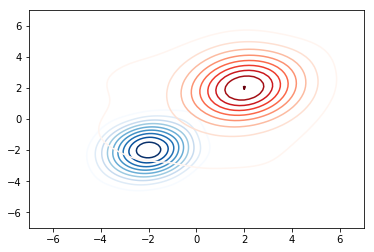

In [5]:
sns.kdeplot(model.theta.data[:, 0, 0], model.theta.data[:, 0, 1], cmap='Blues')
ax = sns.kdeplot(model.theta.data[:, 1, 0], model.theta.data[:, 1, 1], cmap='Reds')
ax.set_xlim(-7, 7)
ax.set_ylim(-7, 7)

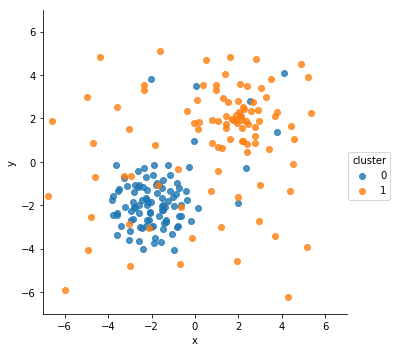

In [6]:
df1 = pd.DataFrame(model.theta.data[:, 0, :], columns=['x', 'y'])
df1['cluster'] = 0
df2 = pd.DataFrame(model.theta.data[:, 1, :], columns=['x', 'y'])
df2['cluster'] = 1
df = pd.concat([df1, df2])

ax = sns.lmplot(x='x', y='y', hue='cluster', data=df, fit_reg=False).set(xlim=(-7, 7), ylim=(-7, 7))